# MODERN PORTFOLIO THEORY & CAPITAL ASSET PRICING MODEL

## 0) Set-up

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [2]:
from library.main import Portfolio

In [3]:
portfolio = Portfolio()

In [4]:
portfolio.extract_tickers()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [5]:
start_date = "2022-01-01"
end_date = "2024-12-31"
list_of_tickers = ["AAPL", "CAT", "JPM"]

In [6]:
portfolio.update_tickers(list_of_tickers, start_date, end_date)

=> Downloading data for AAPL from 2022-01-01 to 2024-12-31


[*********************100%***********************]  1 of 1 completed


=> Downloading data for CAT from 2022-01-01 to 2024-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=> Downloading data for JPM from 2022-01-01 to 2024-12-31


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(info['metrics'].loc["mean"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:198: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  std = float(info['metrics'].loc["std"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min = float(info['metrics'].loc["min"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:200: FutureWarning: Calling floa

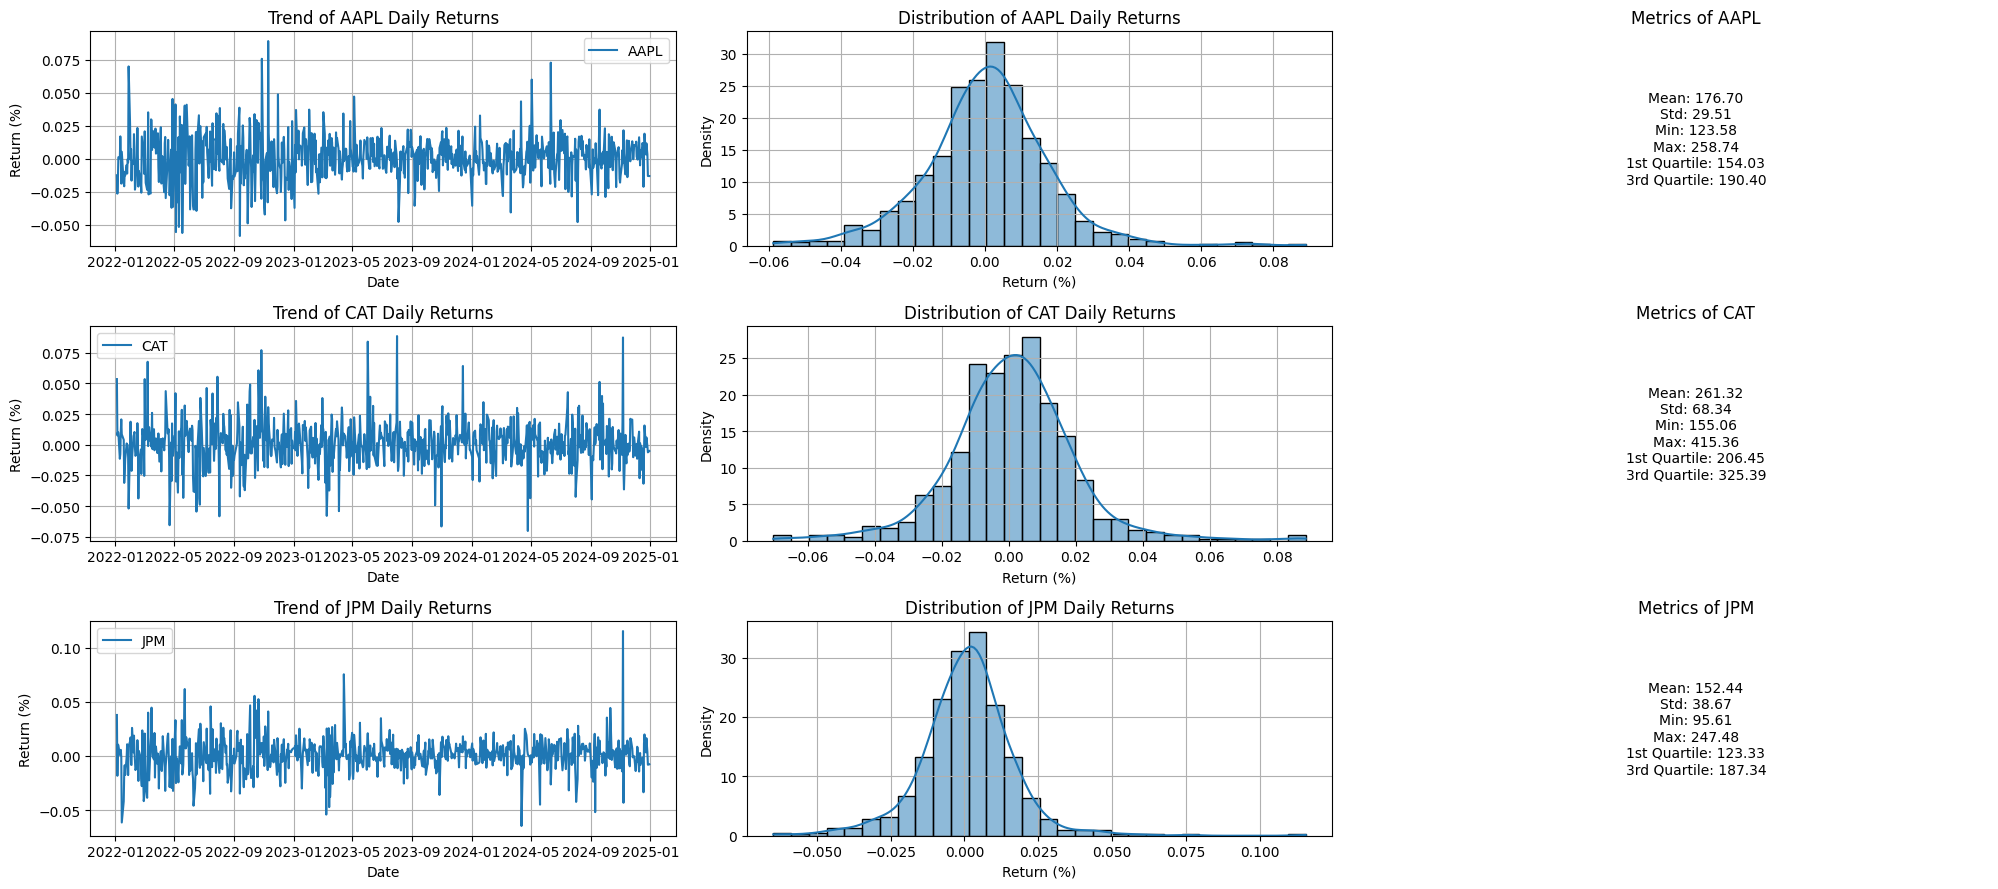

In [7]:
portfolio.analyze_securities()

Now lets observe the expected returns if we were to invest solely in a single asset

In [8]:
portfolio.data_extractor.analayze_single_security_returns()

Security: AAPL
Mean expected return: 0.0006013150393023615
Risk: 0.017065020973922707


Security: CAT
Mean expected return: 0.0010000595516813826
Risk: 0.01861401717872115


Security: JPM
Mean expected return: 0.0007575951285293824
Risk: 0.0157430028428536




/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


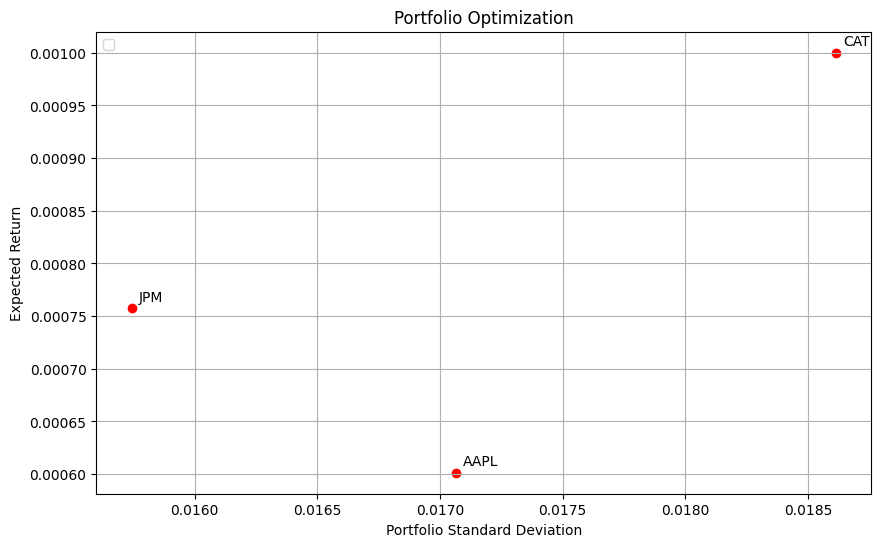

In [9]:
portfolio.plots.plot_results(include_individual_securities=True)

As you will be able to observe in our library, the way we extract returns is by levearing yfinance's dataframe column 'Adj close'. It stands for adjusted close (price) and it account for the splits and dividends over time. We then compute the percentage change over time of this returns (current value and prior). Note these measures are taken on a daily basis. If you are interested into reading more about this way of computing the returns, you can [read yahoo's blog](https://help.yahoo.com/kb/SLN28256.html#:~:text=What%20is%20the%20adjusted%20close%3F).

In accordance with the CER (cosntant expected return) model -- returns follow a i.i.d normal distribution we need to check the fitting of such distribution and alert of possible violations of this assumption.

<hr>

## 1) Extracting matrices 

In [10]:
portfolio.data_extractor.compute_matrices()

In [11]:
portfolio.data_extractor.SIGMA

array([[2.91603227e-04, 9.55197909e-05, 9.44144108e-05],
       [9.55197909e-05, 3.46943611e-04, 1.47978898e-04],
       [9.44144108e-05, 1.47978898e-04, 2.48172595e-04]])

In [12]:
portfolio.data_extractor.SIGMA_INV

array([[ 4004.20082072,  -607.08087441, -1161.36555274],
       [ -607.08087441,  3957.40749459, -2128.74276736],
       [-1161.36555274, -2128.74276736,  5740.59619479]])

In [13]:
portfolio.data_extractor.MU

array([[0.00060132],
       [0.00100006],
       [0.0007576 ]])

In [14]:
portfolio.data_extractor.ONE_VECTOR

array([[1.],
       [1.],
       [1.]])

In [15]:
# Lets update the class with the new computed data
portfolio.update_data()

# 2) Global Minimum Variance Portfolio
A baseline for our modelling in the risk-return space

In [16]:
results_dict = portfolio.compute_global_minimum_variance_portfolio()

In [17]:
results_dict["weights"], results_dict["weights"].sum()

(array([[0.37843944],
        [0.20677383],
        [0.41478673]]),
 np.float64(0.9999999999999998))

In [18]:
results_dict["expected_return"], results_dict["expected_variance"]

(0.0007485878776694727, 0.00016926699931672367)

# 3) Efficient Portfolios
Note we do not restrict to long positions on the securities. We allow for shorting

In [19]:
df = portfolio.compute_efficient_frontier()
df

Min u: 0.0006013150393023615, Max u: 0.0010000595516813826


,weights,variance,sigma,expected_return
0,"[[0.6733302534435684], [-0.21055450723838076],...",0.000227,0.015065,0.000601
1,"[[0.665265369633907], [-0.19914111491505215], ...",0.000224,0.014961,0.000605
2,"[[0.6572004858242462], [-0.187727722591723], [...",0.000221,0.014860,0.000609
3,"[[0.6491356020145848], [-0.17631433026839416],...",0.000218,0.014761,0.000613
4,"[[0.6410707182049231], [-0.16490093794506513],...",0.000215,0.014664,0.000617
...,...,...,...,...
95,"[[-0.09283370847425995], [0.8737177634778666],...",0.000317,0.017793,0.000984
96,"[[-0.10089859228392159], [0.8851311558011952],...",0.000322,0.017936,0.000988
97,"[[-0.10896347609358284], [0.8965445481245247],...",0.000327,0.018079,0.000992
98,"[[-0.11702835990324356], [0.9079579404478533],...",0.000332,0.018224,0.000996


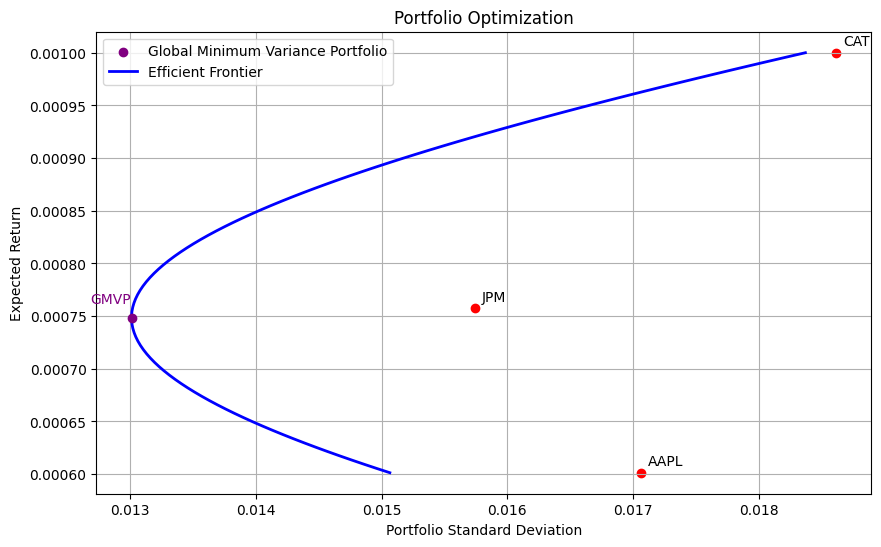

In [20]:
portfolio.plots.plot_results(include_gmvp=True, include_efficient_frontier=True, include_individual_securities=True)

# 4) Capital Asset Pricing Model

In [21]:
annual_risk_free_rate = 0.02
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1 # Formula (assuming 252 days of trading)
daily_risk_free_rate

7.85849419846496e-05

In [22]:
results_dict = portfolio.compute_sharpe_portfolio(daily_risk_free_rate)

In [23]:
results_dict["weights"]

array([[0.18824622],
       [0.47593454],
       [0.33581924]])

In [24]:
results_dict["expected_return"]

0.0008435731867947002

In [25]:
results_dict["expected_variance"]

0.0001932637273883181

In [26]:
results_dict["sharpe_ratio"]

0.055027475101446205

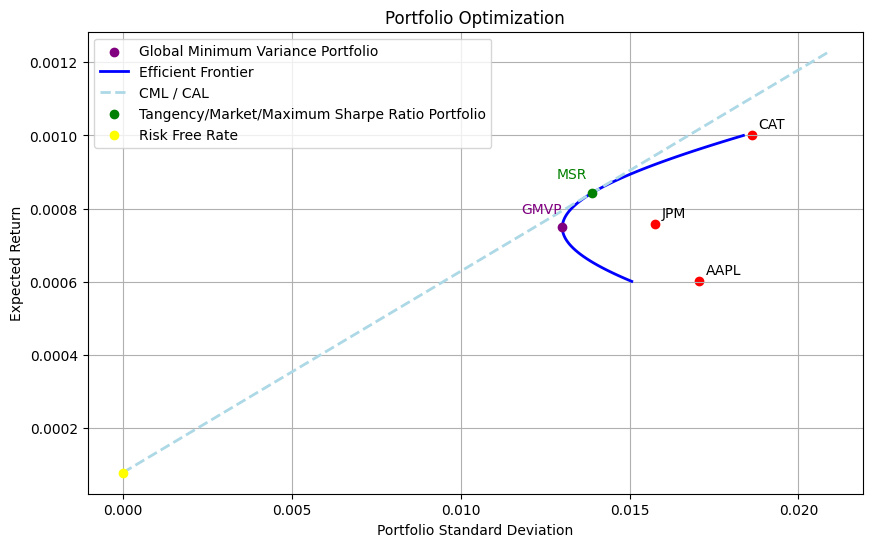

In [27]:
portfolio.plots.plot_results(include_gmvp=True, include_efficient_frontier=True, include_sharpe=True, include_individual_securities=True)